In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import cv2

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import apply_affine_transform
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D, BatchNormalization, Dropout, Flatten, GlobalMaxPooling2D,Input,GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import preprocess_input
import keras_cv

Using TensorFlow backend


In [2]:
train_csv_path = '/kaggle/input/UBC-OCEAN/train.csv'
test_csv_path = '/kaggle/input/UBC-OCEAN/test.csv'

train = pd.read_csv(train_csv_path)
train

,image_id,label,image_width,image_height,is_tma
0,4,HGSC,23785,20008,False
1,66,LGSC,48871,48195,False
2,91,HGSC,3388,3388,True
3,281,LGSC,42309,15545,False
4,286,EC,37204,30020,False
...,...,...,...,...,...
533,65022,LGSC,53355,46675,False
534,65094,MC,55042,45080,False
535,65300,HGSC,75860,27503,False
536,65371,HGSC,42551,41800,False


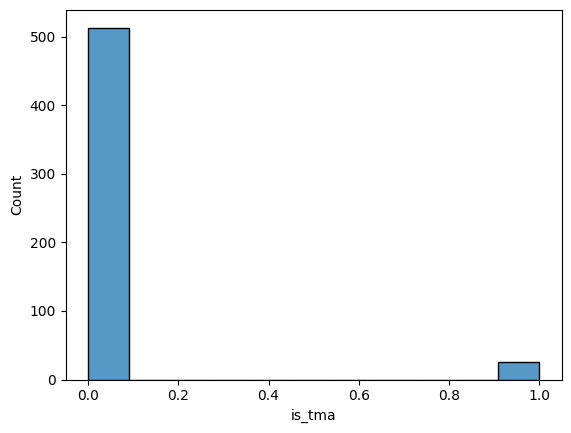

In [3]:
sns.histplot(train.is_tma)
plt.show()

In [4]:
class_labels = {'CC':0, 'EC':1, 'HGSC':2, 'LGSC':3, 'MC':4}
display(class_labels)

{'CC': 0, 'EC': 1, 'HGSC': 2, 'LGSC': 3, 'MC': 4}

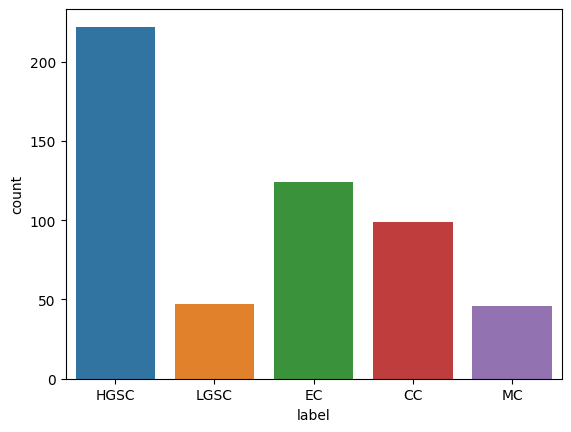

In [5]:
sns.countplot(x=train.label)
plt.show()

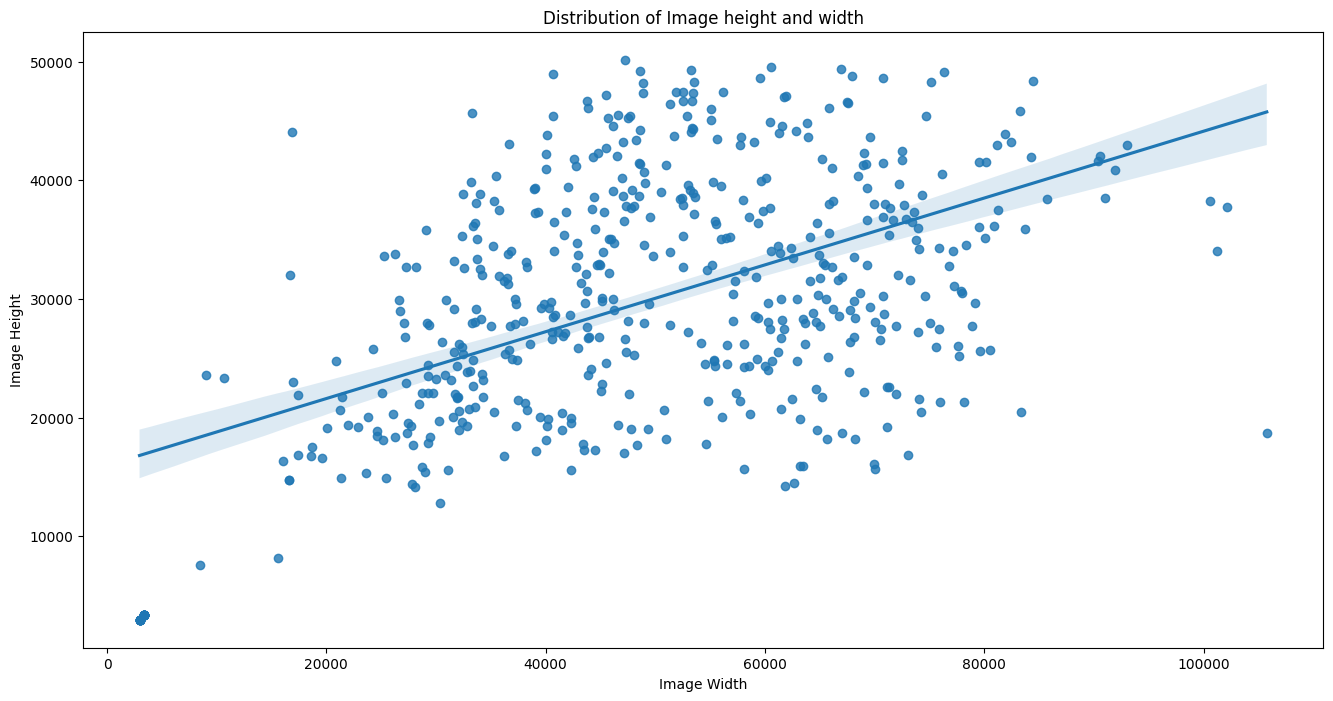

In [6]:
plt.figure(figsize=(16,8))
sns.regplot(data = train,x='image_width', y ='image_height')
plt.xlabel('Image Width')
plt.ylabel('Image Height')
plt.title("Distribution of Image height and width")
plt.show()

## Data Preprocessing

In [7]:
def simplification(dataframe):
    dataframe['label'] = dataframe['label'].replace({'CC':0, 'EC':1, 'HGSC':2, 'LGSC':3, 'MC':4})
    dataframe['is_tma'] = dataframe['is_tma'].astype('int8')
    dataframe['image_id'] = dataframe['image_id'].astype('int32')
    dataframe['label'] = dataframe['label'].astype('int8')
    dataframe['image_width'] = dataframe['image_width'].astype('int32')
    dataframe['image_height'] = dataframe['image_height'].astype('int32')
    
    return dataframe

In [8]:
train = simplification(train)
train

,image_id,label,image_width,image_height,is_tma
0,4,2,23785,20008,0
1,66,3,48871,48195,0
2,91,2,3388,3388,1
3,281,3,42309,15545,0
4,286,1,37204,30020,0
...,...,...,...,...,...
533,65022,3,53355,46675,0
534,65094,4,55042,45080,0
535,65300,2,75860,27503,0
536,65371,2,42551,41800,0


# Data Loading

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

thumbnail_dir = "/kaggle/input/UBC-OCEAN/train_thumbnails"
image_dir = "/kaggle/input/UBC-OCEAN/train_images"

In [10]:
def create_filename_on_tma(dataframe, thumbnails_directory, images_directory):
    thumbnails_files = os.listdir(thumbnails_directory)
    image_files = os.listdir(images_directory)

    train_thumbnails_df = train[train['is_tma'] == 0]
    train_images_df = train[train['is_tma'] == 1]

    thumbs_df = pd.DataFrame({'file_path' : thumbnails_files})
    thumbs_df['image_id'] = thumbs_df['file_path'].str.extract(r'(\d+)').astype('int')

    image_df = pd.DataFrame({'file_path': image_files})
    image_df['image_id'] = image_df['file_path'].str.extract(r'(\d+)').astype('int')

    thumbs_df = thumbs_df.merge(train_thumbnails_df[['image_id', 'label']], on=['image_id'], how='inner')
    image_df = image_df.merge(train_images_df[['image_id','label']], on=['image_id'], how='inner')

    image_label_df = pd.concat([thumbs_df, image_df])
    
    return image_label_df

def combine_image_paths_labels(thumbnail_dir, image_dir, image_label_df):
    thumbnail_files = os.listdir(thumbnail_dir)
    image_files = os.listdir(image_dir)

    all_paths = []
    all_labels = []
    labels = image_label_df['label'].values
    
    for index, value in enumerate(image_label_df['file_path'].values):
        if value in thumbnail_files:
            mod_path = os.path.join(thumbnail_dir, value)
        else:
            mod_path = os.path.join(image_dir, value)

        all_paths.append(mod_path)
        all_labels.append(labels[index])

    new_dataframe = pd.DataFrame({'file_path': all_paths, 'label': all_labels})
    return new_dataframe


image_label_df = create_filename_on_tma(train, thumbnail_dir, image_dir)
new_dataframe = combine_image_paths_labels(thumbnail_dir, image_dir, image_label_df)

## Dataset Loader

In [11]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [12]:
class UBCDataset(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size, image_size, shuffle=True, augmentations=None):
        self.df = df
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augmentations = augmentations
        self.indices = np.arange(len(self.df))
        
        if self.shuffle:
            np.random.shuffle(self.indices)
        
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
        
    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_indices = self.indices[start:end]
        
        X = np.empty((len(batch_indices), *self.image_size, 3))
        y = np.empty(len(batch_indices))
        
        for i, idx in enumerate(batch_indices):
            img_path = self.df.iloc[idx]['file_path']
            label = self.df.iloc[idx]['label']
            img = self.load_and_preprocess_image(img_path)
            if self.augmentations is not None:
                img = apply_affine_transform(img, **self.augmentations)
            X[i] = img
            y[i] = label
        
        return X, y
    
    def load_and_preprocess_image(self, image_path):
        # Load and preprocess the image using OpenCV
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.image_size[1], self.image_size[0]))
        img = img / 255.0  
        return img


In [13]:
train_df, val_df = train_test_split(new_dataframe, test_size=0.2)
batch_size = 9 * len(tf.config.experimental.list_physical_devices('GPU'))
image_size = (1024, 1024) 
shuffle = True
augmentations = {
    'theta': 20,  # Rotation angle in degrees
    'tx': 0.2,  # Shift in the x-axis
    'ty': 0.2,  # Shift in the y-axis
    'shear': 0.2,  # Shear angle in degrees
    'zx': 1.1,  # Limiting horizontal zoom to 10% (up to 110%)
    'zy': 1.1,  # Limiting vertical zoom to 10% (up to 110%)
    'row_axis': 0,
    'col_axis': 1,
    'channel_axis': 2
}

train_dataset = UBCDataset(train_df, batch_size, image_size, shuffle, augmentations)
val_dataset = UBCDataset(val_df, batch_size, image_size, shuffle, None)

train_data_loader = tf.data.Dataset.from_generator(
    lambda: train_dataset,
    output_signature=(
        tf.TensorSpec(shape=(None, *image_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
)

val_data_loader = tf.data.Dataset.from_generator(
    lambda: val_dataset,
    output_signature=(
        tf.TensorSpec(shape=(None, *image_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
)

# Model Building

## Callbacks

In [14]:
EPOCHS = 25

class CustomCallback(Callback):
    def __init__(self, target_accuracy=0.90):
        super(CustomCallback, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_sparse_categorical_accuracy')
        if val_accuracy is not None and val_accuracy >= self.target_accuracy:
            print(f"\nReached target accuracy ({self.target_accuracy}), stopping training!")
            self.model.stop_training = True

custom_callback = CustomCallback(target_accuracy=0.85)

early_stopper = EarlyStopping(monitor='sparse_categorical_accuracy',
                              min_delta= 0.01,
                              patience = 3,
                              restore_best_weights=True
                             )
#Learning Rate
class LearningRateMetric(tf.keras.metrics.Metric):
    def __init__(self, name='learning_rate', **kwargs):
        super(LearningRateMetric, self).__init__(name=name, **kwargs)
        self.learning_rates = []

    def update_state(self, y_true, y_pred, sample_weight=None):
        current_lr = tf.keras.backend.get_value(self.model.optimizer.lr)
        self.learning_rates.append(current_lr)

    def result(self):
        return self.learning_rates

class CyclicLR(tf.keras.callbacks.Callback):
    def __init__(self, base_lr=1e-4, max_lr=1e-2, step_size=8, mode='triangular'):
        super(CyclicLR, self).__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.clr_iterations = 0
        self.trn_iterations = 0
        self.history = {}

    def clr(self):
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)

        if self.mode == 'triangular':
            return self.base_lr + (self.max_lr - self.base_lr) * max(0, 1 - x)
        elif self.mode == 'triangular2':
            return self.base_lr + (self.max_lr - self.base_lr) * max(0, 1 - x) / (2 ** (cycle - 1))

    def on_train_begin(self, logs=None):
        logs = logs or {}
        if self.clr_iterations == 0:
            tf.keras.backend.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            tf.keras.backend.set_value(self.model.optimizer.lr, self.clr())

    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1
        self.history.setdefault('lr', []).append(tf.keras.backend.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        tf.keras.backend.set_value(self.model.optimizer.lr, self.clr())
        
        
clr = CyclicLR(base_lr=1e-4, max_lr=1e-2, step_size=8, mode='triangular')

In [15]:
strategy = tf.distribute.MirroredStrategy(devices=['/gpu:0', '/gpu:1'])

with strategy.scope():
    
    base_model = keras_cv.models.DenseNet201Backbone(include_rescaling=False, 
                                                    input_tensor=Input(shape=(*image_size,3))) 
    
    
    base_model.trainable = False

    model = Sequential(
        [
            base_model,
            GlobalAveragePooling2D(),
            BatchNormalization(epsilon=1e-05, momentum=0.1),
            
            Dense(5, activation='softmax')
        ])
    model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_net_backbone (DenseNe  (None, 32, 32, 1920)     18321984  
 tBackbone)                                                      
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 5)                 9605      
                                                                 
Total params: 18,339,269
Trainable params: 13,445
Non-trainable params: 18,325,824
_______________________________________

In [17]:
hist = model.fit(train_data_loader, validation_data=val_data_loader ,epochs=EPOCHS , callbacks=[custom_callback, early_stopper])

Epoch 1/25
24/24 [==============================] - 304s 11s/step - loss: 1.7054 - sparse_categorical_accuracy: 0.2488 - val_loss: 1.6556 - val_sparse_categorical_accuracy: 0.3611
Epoch 2/25
24/24 [==============================] - 229s 10s/step - loss: 1.6443 - sparse_categorical_accuracy: 0.3000 - val_loss: 1.6255 - val_sparse_categorical_accuracy: 0.3519
Epoch 3/25
24/24 [==============================] - 228s 9s/step - loss: 1.6015 - sparse_categorical_accuracy: 0.3233 - val_loss: 1.6088 - val_sparse_categorical_accuracy: 0.3519
Epoch 4/25
24/24 [==============================] - 227s 9s/step - loss: 1.5694 - sparse_categorical_accuracy: 0.3535 - val_loss: 1.5993 - val_sparse_categorical_accuracy: 0.3519
Epoch 5/25
24/24 [==============================] - 234s 10s/step - loss: 1.5448 - sparse_categorical_accuracy: 0.3581 - val_loss: 1.5939 - val_sparse_categorical_accuracy: 0.3704
Epoch 6/25
24/24 [==============================] - 245s 10s/step - loss: 1.5255 - sparse_categorical_

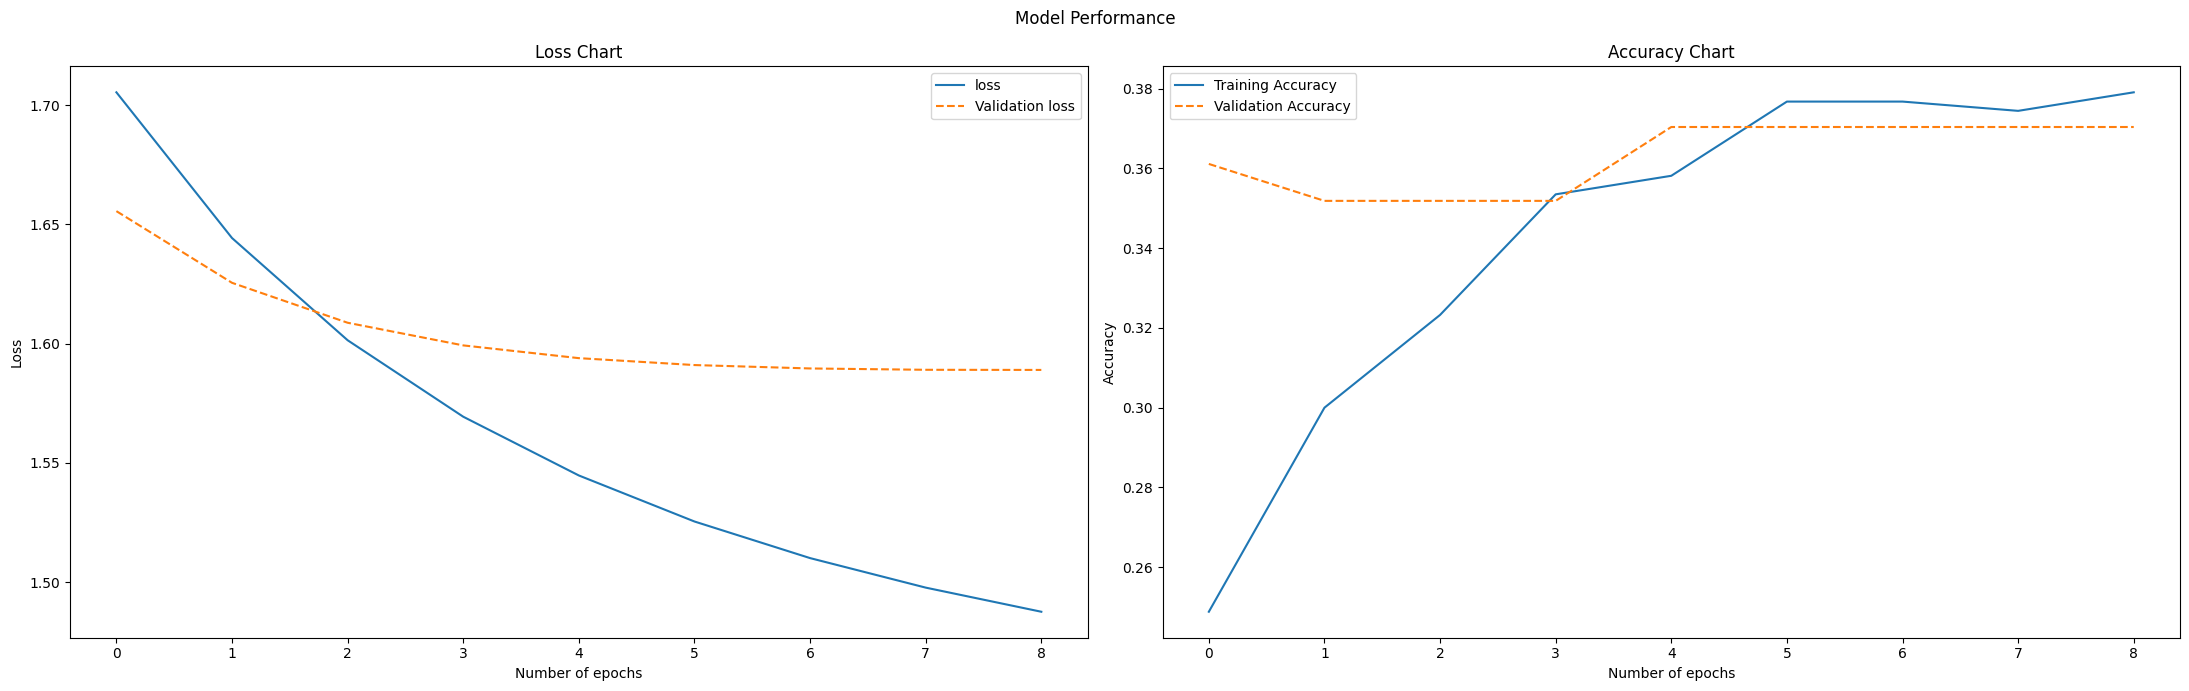

In [18]:
fig, axes = plt.subplots(ncols=2, figsize= (22,7))
sns.lineplot(hist.history['loss'], ax= axes[0], label='loss')
sns.lineplot(hist.history['val_loss'], ax=axes[0], label='Validation loss', linestyle='--')
axes[0].set_xlabel('Number of epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Chart')

sns.lineplot(hist.history['sparse_categorical_accuracy'], ax=axes[1], label='Training Accuracy')
sns.lineplot(hist.history['val_sparse_categorical_accuracy'], ax=axes[1], label='Validation Accuracy', linestyle='--')
axes[1].set_xlabel('Number of epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Chart')

plt.suptitle('Model Performance')
plt.tight_layout()
plt.show()

# Submission

In [19]:
id_to_name = {key:value for value, key in class_labels.items()}

In [20]:
# Testng paths
test_csv_path = "/kaggle/input/UBC-OCEAN/test.csv"
test_thumbnail_dir = "/kaggle/input/UBC-OCEAN/test_thumbnails"
output_csv_path = "submission.csv"

# Load the test CSV
test_df = pd.read_csv(test_csv_path)

# Initialize lists to store image IDs and predictions
image_ids = []
predictions = []

# Iterate through the test DataFrame
for index, row in test_df.iterrows():
    image_id = row['image_id']
    image_path = os.path.join(test_thumbnail_dir, str(image_id)) + '_thumbnail.png'

    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(1024, 1024))
    img = image.img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)

    # Make predictions using your model
    prediction = model.predict(img)
    predicted = np.argmax(prediction)
    predicted_class = id_to_name[predicted]

    image_ids.append(image_id)
    predictions.append(predicted_class)

submission_df = pd.DataFrame({'image_id': image_ids, 'label': predictions})

submission_df.to_csv(output_csv_path, index=False)

1/1 [==============================] - 13s 13s/step
